In [51]:
# 🚀 LSTM Time Embedding Comparison - Complete Setup Cell
print("🔧 Setting up LSTM Time Embedding Comparison...")

# Core imports
import os
import sys
import time
import json
import csv
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Data processing
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from tqdm.auto import tqdm # Import tqdm

# Add project root to path
project_root = '/home/s2516027/kan-mammote'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules
from src.models.kan_mammote import KANMAMMOTE
from src.utils.config import KANMAMOTEConfig
from src.LETE.LeTE import CombinedLeTE as LeTE # Import CombinedLeTE and alias it as LeTE

# Configuration
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
LSTM_HIDDEN_DIM = 128
TIME_EMBEDDING_DIM = 64
DROPOUT_RATE = 0.2
THRESHOLD = 0.3
GRAD_CLIP_NORM = 1.0

# Setup device and directories
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

RESULTS_DIR = f"{project_root}/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

class EventBasedMNIST(Dataset):
    """Convert MNIST to event-based representation."""
    
    def __init__(self, root, train=True, threshold=0.3, download=False):
        self.threshold = threshold
        transform = transforms.Compose([transforms.ToTensor()])
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        
    def __len__(self):
        return len(self.mnist)
        
    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        
        # Convert to event representation
        image = image.squeeze().numpy()
        
        # Create events for pixels above threshold
        events = []
        features = []
        
        for i in range(28):
            for j in range(28):
                if image[i, j] > self.threshold:
                    position = i * 28 + j  # Flatten position
                    events.append(position)
                    features.append(image[i, j])
        
        if len(events) == 0:
            events = [0]
            features = [0.0]
        
        return np.array(events), np.array(features), label

def collate_fn(batch):
    """Custom collate function for variable length sequences."""
    events_batch = []
    features_batch = []
    lengths = []
    labels = []
    
    max_len = max(len(events) for events, _, _ in batch)
    
    for events, features, label in batch:
        length = len(events)
        lengths.append(length)
        labels.append(label)
        
        # Pad sequences
        padded_events = np.zeros(max_len, dtype=np.int64)
        padded_features = np.zeros(max_len, dtype=np.float32)
        
        padded_events[:length] = events
        padded_features[:length] = features
        
        events_batch.append(padded_events)
        features_batch.append(padded_features)
    
    return (torch.tensor(events_batch), 
            torch.tensor(features_batch), 
            torch.tensor(lengths), 
            torch.tensor(labels))

def count_parameters(model):
    """Count trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TrueBaselineLSTM(nn.Module):
    """True baseline LSTM without any time embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Just use feature values directly
        self.lstm = nn.LSTM(
            input_size=1,  # Just the pixel values
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        if features.size(0) == 0:
            return torch.zeros(0, 10, device=features.device)
        
        lengths = torch.clamp(lengths, min=1, max=features.size(1))
        
        # Use only pixel values, no positional information
        x = features.unsqueeze(-1)  # Add feature dimension
        
        # Pack sequences
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify using last hidden state
        output = self.classifier(h_n[-1])
        return output

class LearnablePositionLSTM(nn.Module):
    """LSTM with learnable position embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        # Learnable position embedding
        self.position_embedding = nn.Embedding(input_size, TIME_EMBEDDING_DIM)
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        if events.size(0) == 0:
            return torch.zeros(0, 10, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Get position embeddings
        pos_emb = self.position_embedding(events)
        
        # Project features
        feat_emb = self.feature_proj(features.unsqueeze(-1))
        
        # Combine position and feature embeddings
        combined = pos_emb + feat_emb
        
        # Pack sequences
        packed = pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify
        output = self.classifier(h_n[-1])
        return output

class SinCosLSTM(nn.Module):
    """LSTM with sinusoidal position embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def get_sincos_embeddings(self, positions):
        """Generate sinusoidal position embeddings."""
        batch_size, seq_len = positions.shape
        embeddings = torch.zeros(batch_size, seq_len, TIME_EMBEDDING_DIM, device=positions.device)
        
        # Normalize positions to [0, 1]
        max_pos = positions.max(dim=1, keepdim=True)[0].float()
        normalized_pos = positions.float() / (max_pos + 1e-8)
        
        div_term = torch.exp(torch.arange(0, TIME_EMBEDDING_DIM, 2, device=positions.device).float() * 
                            -(np.log(10000.0) / TIME_EMBEDDING_DIM))
        
        pos_scaled = normalized_pos.unsqueeze(-1) * div_term.unsqueeze(0).unsqueeze(0)
        
        embeddings[:, :, 0::2] = torch.sin(pos_scaled)
        embeddings[:, :, 1::2] = torch.cos(pos_scaled)
        
        return embeddings
        
    def forward(self, events, features, lengths):
        if events.size(0) == 0:
            return torch.zeros(0, 10, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Get sinusoidal position embeddings
        pos_emb = self.get_sincos_embeddings(events)
        
        # Project features
        feat_emb = self.feature_proj(features.unsqueeze(-1))
        
        # Combine embeddings
        combined = pos_emb + feat_emb
        
        # Pack sequences
        packed = pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify
        output = self.classifier(h_n[-1])
        return output

class LETE_LSTM_Fixed(nn.Module):
    """LSTM with LETE time embeddings - FIXED."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize LETE
        self.lete = LeTE(dim=TIME_EMBEDDING_DIM)
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        # Input validation
        if events.size(0) == 0:
            return torch.zeros(0, 10, device=events.device)
        
        # Clamp lengths to prevent issues
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Normalize timestamps
        max_pos = events.max(dim=1, keepdim=True)[0].float()
        # Prevent division by zero
        max_pos[max_pos == 0] = 1.0
        timestamps = events.float() / max_pos
        
        # Get LETE embeddings
        timestamps_3d = timestamps.unsqueeze(-1)
        lete_emb = self.lete(timestamps_3d)
        
        # Handle shape mismatches
        batch_size, seq_len = timestamps.shape
        if lete_emb.shape != (batch_size, seq_len, TIME_EMBEDDING_DIM):
            if lete_emb.dim() == 3:
                # Take only what we need
                lete_emb = lete_emb[:, :seq_len, :TIME_EMBEDDING_DIM]
            else:
                # Reshape as needed
                lete_emb = lete_emb.view(batch_size, seq_len, -1)
                if lete_emb.shape[2] != TIME_EMBEDDING_DIM:
                    # Project to correct dimension
                    if not hasattr(self, 'lete_proj'):
                        self.lete_proj = nn.Linear(lete_emb.shape[2], TIME_EMBEDDING_DIM).to(lete_emb.device)
                    lete_emb = self.lete_proj(lete_emb)
        
        # Clip to prevent numerical issues
        lete_emb = torch.clamp(lete_emb, min=-1e3, max=1e3)
        
        # Project features
        feat_emb = self.feature_proj(features.unsqueeze(-1))
        
        # Combine embeddings
        combined = lete_emb + feat_emb
        combined = F.relu(combined)
        
        # LSTM processing
        packed = pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify
        output = self.classifier(h_n[-1])
        return output
class KAN_MAMMOTE_LSTM_Fixed(nn.Module):
    """LSTM with KAN-MAMMOTE that processes the entire sequence."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        # Fix 1: Update timestamp projection dimension
        # The input is a scalar (dimension 1), and the output needs to match input_feature_dim in KAN config
        self.timestamp_proj = nn.Linear(1, 16)
        
        # Initialize KAN-MAMMOTE with appropriate settings
        self.kan_config = KANMAMOTEConfig(
            D_time=TIME_EMBEDDING_DIM,
            d_model=LSTM_HIDDEN_DIM,
            input_feature_dim=16,  # Must match output dim of timestamp_proj
            output_dim_for_task=TIME_EMBEDDING_DIM,
            K_top=4,
            use_aux_features_router=False,
            raw_event_feature_dim=1,
            num_layers=1,
            num_experts=4
        )
        
        self.kan_mammote = KANMAMMOTE(self.kan_config)
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        # Combine embeddings
        self.combine = nn.Linear(TIME_EMBEDDING_DIM * 2, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        # Input validation
        if events.size(0) == 0:
            return torch.zeros(0, self.num_classes, device=events.device)
        
        # Clamp lengths to prevent issues
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Filter valid sequences
        valid_mask = lengths > 0
        if not valid_mask.any():
            return torch.zeros(events.size(0), self.num_classes, device=events.device)
        
        events_valid = events[valid_mask]
        features_valid = features[valid_mask]
        lengths_valid = lengths[valid_mask]
        
        # Normalize timestamps
        max_pos = events_valid.max(dim=1, keepdim=True)[0].float()
        max_pos[max_pos == 0] = 1.0
        timestamps = events_valid.float() / (max_pos + 1e-8)
        
        batch_size, max_seq_len = events_valid.shape
        
         # Create sequence mask to handle variable lengths
        seq_mask = torch.arange(max_seq_len, device=lengths_valid.device)[None, :] < lengths_valid[:, None]
        
        # Process all positions at once - KEY OPTIMIZATION
        
        # 1. Project all timestamps
        # Shape: [batch_size, seq_len, 1] -> [batch_size, seq_len, 16]
        all_timestamp_proj = self.timestamp_proj(timestamps.unsqueeze(-1))
        
        # 2. Create empty features tensor matching the expected dimensions
        # Shape: [batch_size, seq_len, 16]
        all_features = torch.zeros(batch_size, max_seq_len, 16, device=timestamps.device)
        
        # 3. Apply mask to both tensors to handle padding properly
        # This step is important to ensure we don't process padding tokens
        masked_timestamp_proj = all_timestamp_proj * seq_mask.unsqueeze(-1).float()
        masked_features = all_features * seq_mask.unsqueeze(-1).float()
        
        # 4. Process through KAN-MAMMOTE in a single forward pass
        try:
            # Reshape for processing
            # From [batch_size, seq_len, 16] to [batch_size * seq_len, 16]
            flat_timestamps = masked_timestamp_proj.view(-1, 16)
            flat_features = masked_features.view(-1, 1, 16)  # Keep the seq_len dim of 1 for each position
            
            # Skip zeros (padding) to save computation
            nonzero_mask = ~(flat_timestamps.sum(dim=-1) == 0)
            if nonzero_mask.any():
                nonzero_timestamps = flat_timestamps[nonzero_mask]
                nonzero_features = flat_features[nonzero_mask]
                
                # Process through KAN-MAMMOTE
                nonzero_outputs, _ = self.kan_mammote(nonzero_timestamps, nonzero_features)
                if nonzero_outputs.dim() == 3 and nonzero_outputs.shape[1] == 1:
                    # Remove the middle dimension
                    nonzero_outputs = nonzero_outputs.squeeze(1)
                # Initialize output tensor
                flat_outputs = torch.zeros(
                    flat_timestamps.size(0), TIME_EMBEDDING_DIM, 
                    device=flat_timestamps.device
                )
                
                # Place outputs back
                flat_outputs[nonzero_mask] = nonzero_outputs
                
                # Reshape back to [batch_size, seq_len, embedding_dim]
                kan_embeddings = flat_outputs.view(batch_size, max_seq_len, -1)
            else:
                # Handle edge case where all are zeros
                kan_embeddings = torch.zeros(batch_size, max_seq_len, TIME_EMBEDDING_DIM, device=timestamps.device)
        
        except Exception as e:
            print(f"Error processing with KAN-MAMMOTE: {e}")
            print(f"Input shapes - timestamp_proj: {masked_timestamp_proj.shape}, features: {masked_features.shape}")
            # Add more detailed error info
            if 'nonzero_outputs' in locals():
                print(f"Output shape from KAN-MAMMOTE: {nonzero_outputs.shape}")
            if 'flat_outputs' in locals():
                print(f"Shape of flat_outputs: {flat_outputs.shape}")
            if 'nonzero_mask' in locals():
                print(f"Nonzero mask shape: {nonzero_mask.shape}, sum: {nonzero_mask.sum()}")
            
            raise
        
        # Project features for the other branch
        feat_emb = self.feature_proj(features_valid.unsqueeze(-1))
        
        # Combine embeddings from both pathways
        combined_valid = torch.cat([kan_embeddings, feat_emb], dim=-1)
        combined_valid = self.combine(combined_valid)
        combined_valid = F.relu(combined_valid)
        
        # Apply sequence mask again to ensure we don't use padding in LSTM
        combined_valid = combined_valid * seq_mask.unsqueeze(-1).float()
        
        # LSTM processing
        packed = pack_padded_sequence(combined_valid, lengths_valid.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classifier
        valid_logits = self.classifier(h_n[-1])
        
        # Create full output tensor
        full_logits = torch.zeros(events.size(0), self.num_classes, device=events.device)
        full_logits[valid_mask] = valid_logits
        
        return full_logits
    
def train_model(model, train_loader, test_loader, model_name):
    """Train a single model with immediate error stopping."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [],
        'epochs': [], 'training_time': []
    }
    
    best_test_acc = 0.0
    
    print(f"Training {model_name}...")
    
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (events, features, lengths, labels) in enumerate(train_pbar):
            # No try-except here - let errors propagate and stop execution
            events, features, lengths, labels = events.to(device), features.to(device), lengths.to(device), labels.to(device)
            
            # Debug info for first few batches
            '''if batch_idx < 3:
                print(f"\n📊 Batch {batch_idx} debug:")
                print(f"  - events: shape={events.shape}, range=[{events.min().item()}, {events.max().item()}]")
                print(f"  - features: shape={features.shape}, range=[{features.min().item()}, {features.max().item()}]")
                print(f"  - lengths: shape={lengths.shape}, range=[{lengths.min().item()}, {lengths.max().item()}]")
                print(f"  - labels: shape={labels.shape}, values={labels.tolist()}")'''
            
            optimizer.zero_grad()
            
            outputs = model(events, features, lengths)
            
            # Check outputs and raise error if issues are found
            if torch.isnan(outputs).any():
                print(f"⚠️ NaN detected in outputs at batch {batch_idx}!")
                raise ValueError(f"NaN detected in model outputs at batch {batch_idx}")
                
            loss = criterion(outputs, labels)
            
            # Check loss and raise error if issues are found
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ NaN/Inf loss detected at batch {batch_idx}: {loss.item()}")
                raise ValueError(f"NaN or Inf loss value detected at batch {batch_idx}: {loss.item()}")
            
            loss.backward()
            
            # Check gradients and raise error if issues are found
            for name, param in model.named_parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    print(f"⚠️ NaN/Inf gradient detected in {name}")
                    raise ValueError(f"NaN or Inf gradient detected in parameter {name}")
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update tqdm postfix
            train_pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*train_correct/train_total:.2f}%")
        
        train_pbar.close()

        # Validation phase
        model.eval()
        test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Test]", leave=False)
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_idx, (events, features, lengths, labels) in enumerate(test_pbar):
                # No try-except here - let errors propagate and stop execution
                events, features, lengths, labels = events.to(device), features.to(device), lengths.to(device), labels.to(device)
                
                outputs = model(events, features, lengths)
                
                # Check outputs and raise error if issues are found
                if torch.isnan(outputs).any():
                    print(f"⚠️ NaN detected in test outputs at batch {batch_idx}!")
                    raise ValueError(f"NaN detected in test model outputs at batch {batch_idx}")
                    
                loss = criterion(outputs, labels)
                
                # Check loss and raise error if issues are found
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ NaN/Inf test loss detected at batch {batch_idx}: {loss.item()}")
                    raise ValueError(f"NaN or Inf test loss value detected at batch {batch_idx}: {loss.item()}")
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                test_pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*test_correct/test_total:.2f}%")
        
        test_pbar.close()

        # Calculate metrics
        epoch_time = time.time() - start_time
        train_acc = 100 * train_correct / max(train_total, 1)  # Avoid division by zero
        test_acc = 100 * test_correct / max(test_total, 1)    # Avoid division by zero
        avg_train_loss = train_loss / max(len(train_loader), 1)  # Avoid division by zero
        avg_test_loss = test_loss / max(len(test_loader), 1)    # Avoid division by zero
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)
        history['epochs'].append(epoch + 1)
        history['training_time'].append(epoch_time)
        
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.1f}s')
    
    print(f"✅ {model_name} training complete. Best test accuracy: {best_test_acc:.2f}%")
    return history, best_test_acc

def plot_training_curves(results):
    """Plot training curves for all models."""
    plt.figure(figsize=(15, 10))
    
    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for model_name, history in results.items():
        if 'train_acc' in history and len(history['train_acc']) > 0:
            plt.plot(history['epochs'], history['train_acc'], label=model_name, marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot test accuracy
    plt.subplot(2, 2, 2)
    for model_name, history in results.items():
        if 'test_acc' in history and len(history['test_acc']) > 0:
            plt.plot(history['epochs'], history['test_acc'], label=model_name, marker='o')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot training loss
    plt.subplot(2, 2, 3)
    for model_name, history in results.items():
        if 'train_loss' in history and len(history['train_loss']) > 0:
            plt.plot(history['epochs'], history['train_loss'], label=model_name, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot test loss
    plt.subplot(2, 2, 4)
    for model_name, history in results.items():
        if 'test_loss' in history and len(history['test_loss']) > 0:
            plt.plot(history['epochs'], history['test_loss'], label=model_name, marker='o')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Training curves saved to {RESULTS_DIR}/training_curves.png")

print("✅ Setup complete! All imports and model definitions loaded.")
print(f"✅ Device: {device}")
print(f"✅ Results directory: {RESULTS_DIR}")
print("🚀 Ready to run the comparison!")

🔧 Setting up LSTM Time Embedding Comparison...
🔧 Using device: cuda
✅ Setup complete! All imports and model definitions loaded.
✅ Device: cuda
✅ Results directory: /home/s2516027/kan-mammote/results
🚀 Ready to run the comparison!


Looking at the error trace, I can see there's a shape mismatch error occurring during the matrix multiplication in the neural network. The error "mat1 and mat2 shapes cannot be multiplied (32x16 and 1x64)" suggests that your KAN-MAMMOTE model has a dimension mismatch between the projected timestamps and the network's expected input shape.

Let me create a test file to help diagnose this issue. I'll focus on testing the model initialization, forward pass, and the key component causing the error.



Made changes.

In [52]:
#check cuda
import torch
if torch.cuda.is_available():
    print("CUDA is available. Running on GPU.")

CUDA is available. Running on GPU.


🚀 Starting LSTM Time Embedding Comparison - FIXED VERSION (STOP ON ERROR)...

📁 Loading datasets...


✅ Dataset loaded: 60000 train, 10000 test samples

📊 Model Information:
   True_Baseline: 200,458 parameters
   Learnable_Position: 283,018 parameters
   SinCos_LSTM: 232,842 parameters
   LETE_LSTM: 252,650 parameters
   KAN_MAMMOTE_LSTM: 418,862 parameters

Starting training for True_Baseline
Training True_Baseline...


Epoch 1/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10: Train Acc: 11.04%, Test Acc: 11.35%, Time: 54.3s


Epoch 2/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10: Train Acc: 19.53%, Test Acc: 26.21%, Time: 52.9s


Epoch 3/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10: Train Acc: 26.35%, Test Acc: 27.07%, Time: 53.2s


Epoch 4/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10: Train Acc: 27.94%, Test Acc: 29.99%, Time: 53.4s


Epoch 5/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10: Train Acc: 41.38%, Test Acc: 63.28%, Time: 53.3s


Epoch 6/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10: Train Acc: 70.64%, Test Acc: 66.31%, Time: 52.9s


Epoch 7/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10: Train Acc: 77.20%, Test Acc: 80.14%, Time: 53.0s


Epoch 8/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10: Train Acc: 80.44%, Test Acc: 82.77%, Time: 53.1s


Epoch 9/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10: Train Acc: 82.51%, Test Acc: 84.46%, Time: 53.0s


Epoch 10/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10: Train Acc: 83.87%, Test Acc: 84.17%, Time: 53.2s
✅ True_Baseline training complete. Best test accuracy: 84.46%

Starting training for Learnable_Position
Training Learnable_Position...

Starting training for Learnable_Position
Training Learnable_Position...


Epoch 1/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10: Train Acc: 72.39%, Test Acc: 87.73%, Time: 60.6s


Epoch 2/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10: Train Acc: 90.24%, Test Acc: 93.58%, Time: 59.7s


Epoch 3/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10: Train Acc: 94.00%, Test Acc: 95.25%, Time: 59.9s


Epoch 4/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10: Train Acc: 95.62%, Test Acc: 95.82%, Time: 59.7s


Epoch 5/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10: Train Acc: 96.51%, Test Acc: 96.30%, Time: 59.9s


Epoch 6/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10: Train Acc: 97.10%, Test Acc: 96.65%, Time: 60.0s


Epoch 7/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10: Train Acc: 97.49%, Test Acc: 96.70%, Time: 59.9s


Epoch 8/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10: Train Acc: 97.83%, Test Acc: 97.20%, Time: 60.1s


Epoch 9/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10: Train Acc: 98.21%, Test Acc: 96.89%, Time: 60.2s


Epoch 10/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10: Train Acc: 98.45%, Test Acc: 97.08%, Time: 59.9s
✅ Learnable_Position training complete. Best test accuracy: 97.20%

Starting training for SinCos_LSTM
Training SinCos_LSTM...


Epoch 1/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10: Train Acc: 50.36%, Test Acc: 70.29%, Time: 60.0s


Epoch 2/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10: Train Acc: 74.71%, Test Acc: 78.67%, Time: 59.9s


Epoch 3/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10: Train Acc: 80.88%, Test Acc: 84.42%, Time: 60.1s


Epoch 4/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10: Train Acc: 85.35%, Test Acc: 86.96%, Time: 60.0s


Epoch 5/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10: Train Acc: 87.74%, Test Acc: 89.35%, Time: 59.9s


Epoch 6/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10: Train Acc: 89.58%, Test Acc: 89.90%, Time: 60.2s


Epoch 7/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10: Train Acc: 90.68%, Test Acc: 89.12%, Time: 60.2s


Epoch 8/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10: Train Acc: 91.64%, Test Acc: 91.91%, Time: 59.5s


Epoch 9/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10: Train Acc: 92.45%, Test Acc: 92.11%, Time: 60.0s


Epoch 10/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10: Train Acc: 92.95%, Test Acc: 92.75%, Time: 59.9s
✅ SinCos_LSTM training complete. Best test accuracy: 92.75%

Starting training for LETE_LSTM
Training LETE_LSTM...


Epoch 1/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10: Train Acc: 45.48%, Test Acc: 69.64%, Time: 71.1s


Epoch 2/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10: Train Acc: 71.78%, Test Acc: 73.58%, Time: 69.2s


Epoch 3/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10: Train Acc: 78.87%, Test Acc: 81.10%, Time: 68.2s


Epoch 4/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10: Train Acc: 82.41%, Test Acc: 83.57%, Time: 68.8s


Epoch 5/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10: Train Acc: 84.19%, Test Acc: 85.46%, Time: 70.3s


Epoch 6/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10: Train Acc: 85.67%, Test Acc: 87.08%, Time: 70.2s


Epoch 7/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10: Train Acc: 87.06%, Test Acc: 86.90%, Time: 68.3s


Epoch 8/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10: Train Acc: 88.00%, Test Acc: 86.85%, Time: 69.5s


Epoch 9/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10: Train Acc: 88.93%, Test Acc: 88.25%, Time: 69.2s


Epoch 10/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10: Train Acc: 89.83%, Test Acc: 88.66%, Time: 69.6s
✅ LETE_LSTM training complete. Best test accuracy: 88.66%

Starting training for KAN_MAMMOTE_LSTM
Training KAN_MAMMOTE_LSTM...


Epoch 1/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10: Train Acc: 47.02%, Test Acc: 69.35%, Time: 204.4s


Epoch 2/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10: Train Acc: 72.03%, Test Acc: 78.26%, Time: 202.8s


Epoch 3/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10: Train Acc: 78.22%, Test Acc: 81.70%, Time: 201.6s


Epoch 4/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10: Train Acc: 81.67%, Test Acc: 83.77%, Time: 202.3s


Epoch 5/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10: Train Acc: 83.71%, Test Acc: 84.82%, Time: 201.9s


Epoch 6/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10: Train Acc: 85.65%, Test Acc: 84.71%, Time: 202.9s


Epoch 7/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10: Train Acc: 87.03%, Test Acc: 87.00%, Time: 203.8s


Epoch 8/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10: Train Acc: 88.11%, Test Acc: 87.67%, Time: 201.4s


Epoch 9/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10: Train Acc: 89.10%, Test Acc: 87.99%, Time: 203.8s


Epoch 10/10 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10: Train Acc: 89.84%, Test Acc: 87.90%, Time: 203.2s
✅ KAN_MAMMOTE_LSTM training complete. Best test accuracy: 87.99%

💾 Saving results...


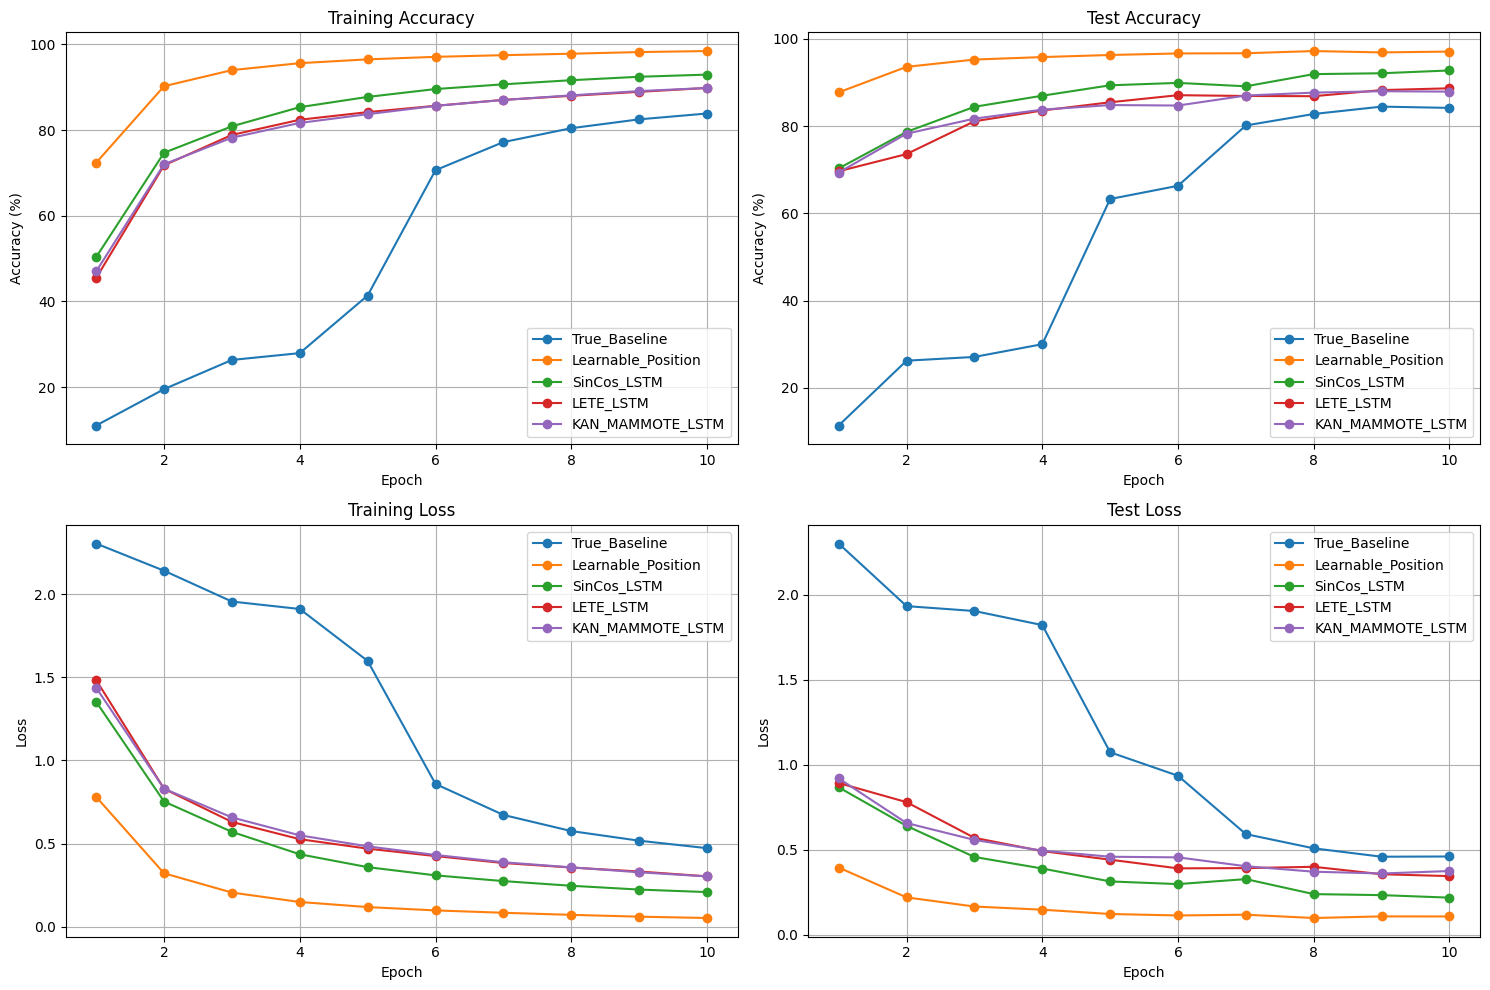

✅ Training curves saved to /home/s2516027/kan-mammote/results/training_curves.png

🎯 FINAL RESULTS SUMMARY:
True_Baseline       : 84.4600 acc | 200,458 params | 53.2s/epoch
Learnable_Position  : 97.2000 acc | 283,018 params | 60.0s/epoch
SinCos_LSTM         : 92.7500 acc | 232,842 params | 60.0s/epoch
LETE_LSTM           : 88.6600 acc | 252,650 params | 69.4s/epoch
KAN_MAMMOTE_LSTM    : 87.9900 acc | 418,862 params | 202.8s/epoch

🏆 Best Model: Learnable_Position (Accuracy: 97.2000)

💾 All results saved to: /home/s2516027/kan-mammote/results
🎉 Comparison complete!


In [53]:
def main():
    """Main execution function with improved error handling - STOP ON ERROR version."""
    print("🚀 Starting LSTM Time Embedding Comparison - FIXED VERSION (STOP ON ERROR)...")
    
    try:
        # Create datasets
        print("\n📁 Loading datasets...")
        train_dataset = EventBasedMNIST(root='./data', train=True, threshold=THRESHOLD, download=True)
        test_dataset = EventBasedMNIST(root='./data', train=False, threshold=THRESHOLD, download=True)
        
        # FIXED: Validate datasets
        if len(train_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("Empty dataset!")
        
        print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test samples")
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
        
    except Exception as e:
        print(f"❌ ERROR LOADING DATASET - STOPPING: {e}")
        import traceback
        traceback.print_exc()
        return  # Stop execution
    
    # Define models to compare
    models = {
        
        'True_Baseline': TrueBaselineLSTM(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
       'Learnable_Position': LearnablePositionLSTM(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        'SinCos_LSTM': SinCosLSTM(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        'LETE_LSTM': LETE_LSTM_Fixed(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        
        'KAN_MAMMOTE_LSTM': KAN_MAMMOTE_LSTM_Fixed(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        )
    }
    
    # Print model information
    print("\n📊 Model Information:")
    for name, model in models.items():
        try:
            param_count = count_parameters(model)
            print(f"   {name}: {param_count:,} parameters")
        except Exception as e:
            print(f"❌ ERROR COUNTING PARAMETERS FOR {name} - STOPPING: {e}")
            import traceback
            traceback.print_exc()
            return  # Stop execution if model parameter counting fails
    
    # Train all models
    results = {}
    best_accuracies = {}
    
    for model_name, model in models.items():
        print(f"\n" + "="*50)
        print(f"Starting training for {model_name}")
        print("="*50)
        
        # No try-except here - let errors propagate and stop execution
        history, best_acc = train_model(model, train_loader, test_loader, model_name)
        results[model_name] = history
        best_accuracies[model_name] = best_acc
        
        # Clean up memory after each model
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Save results
    print("\n💾 Saving results...")
    
    try:
        # Save training histories
        with open(f"{RESULTS_DIR}/training_histories.json", 'w') as f:
            json.dump(results, f, indent=2)
        
        # Save summary results
        summary = {
            'best_accuracies': best_accuracies,
            'model_parameters': {name: count_parameters(models[name]) if name in models else 0 for name in best_accuracies.keys()},
            'configuration': {
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'num_epochs': NUM_EPOCHS,
                'lstm_hidden_dim': LSTM_HIDDEN_DIM,
                'time_embedding_dim': TIME_EMBEDDING_DIM,
                'dropout_rate': DROPOUT_RATE,
                'threshold': THRESHOLD
            }
        }
        
        with open(f"{RESULTS_DIR}/summary.json", 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Create CSV summary
        with open(f"{RESULTS_DIR}/results_summary.csv", 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Model', 'Best_Accuracy', 'Parameters', 'Avg_Time_per_Epoch'])
            
            for model_name in best_accuracies.keys():
                if model_name in results and len(results[model_name]['training_time']) > 0:
                    avg_time = np.mean(results[model_name]['training_time'])
                    params = count_parameters(models[model_name])  # Fixed parameter name
                    writer.writerow([
                        model_name,
                        f"{best_accuracies[model_name]:.4f}",
                        params,
                        f"{avg_time:.2f}"
                    ])
        
        # Create visualizations
        if results:
            plot_training_curves(results)
        
    except Exception as e:
        print(f"❌ ERROR SAVING RESULTS - STOPPING: {e}")
        import traceback
        traceback.print_exc()
        return  # Stop execution
    
    # Print final summary
    print("\n🎯 FINAL RESULTS SUMMARY:")
    print("=" * 80)
    for model_name, acc in best_accuracies.items():
        params = count_parameters(models[model_name])
        if model_name in results and len(results[model_name]['training_time']) > 0:
            avg_time = np.mean(results[model_name]['training_time'])
            print(f"{model_name:20s}: {acc:.4f} acc | {params:7,} params | {avg_time:.1f}s/epoch")
    
    # Find best model
    if best_accuracies and any(acc > 0 for acc in best_accuracies.values()):
        best_model = max(best_accuracies, key=best_accuracies.get)
        print(f"\n🏆 Best Model: {best_model} (Accuracy: {best_accuracies[best_model]:.4f})")
    
    print(f"\n💾 All results saved to: {RESULTS_DIR}")
    print("🎉 Comparison complete!")

# Run the comparison
if __name__ == "__main__":
    main()

In [54]:
# 🧪 Quick Test to Verify Everything Works - STOP ON ERROR
print("🧪 Testing the fixed implementation - STOP ON ERROR...")

# Test if all variables are available
print("✅ All imports successful")
print(f"✅ Device: {device}")
print(f"✅ Configuration loaded:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Time embedding dim: {TIME_EMBEDDING_DIM}")
print(f"   - LSTM hidden dim: {LSTM_HIDDEN_DIM}")
print(f"   - Epochs: {NUM_EPOCHS}")

# Test model instantiation
print("\n📊 Testing Model Instantiation:")
# Only create one model at a time to isolate errors
print("Creating TrueBaselineLSTM...")
true_baseline = TrueBaselineLSTM(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE)
print("✅ TrueBaselineLSTM created successfully")

print("Creating LearnablePositionLSTM...")
learnable_pos = LearnablePositionLSTM(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE)
print("✅ LearnablePositionLSTM created successfully")

print("Creating SinCosLSTM...")
sincos_lstm = SinCosLSTM(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE)
print("✅ SinCosLSTM created successfully")

print("Creating LETE_LSTM_Fixed...")
lete_lstm = LETE_LSTM_Fixed(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE)
print("✅ LETE_LSTM_Fixed created successfully")

print("Creating KAN_MAMMOTE_LSTM_Fixed...")
kan_model = KAN_MAMMOTE_LSTM_Fixed(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE)
print("✅ KAN_MAMMOTE_LSTM_Fixed created successfully")

# Store models for parameter counting
test_models = {
    'True_Baseline': true_baseline,
    'Learnable_Position': learnable_pos,
    'SinCos_LSTM': sincos_lstm,
    'LETE_LSTM': lete_lstm,
    'KAN_MAMMOTE_LSTM': kan_model
}

print("\n📊 Model Parameter Counts:")
for name, model in test_models.items():
    params = count_parameters(model)
    print(f"   {name}: {params:,} parameters")

print("✅ All models instantiated successfully")

# Test model internals - KAN-MAMMOTE model
print("\n🔍 Detailed inspection of KAN_MAMMOTE_LSTM model:")

# Print model structure
print("\n📋 Model Structure:")
print(kan_model)

# Check key components
print("\n📊 Key Component Info:")
print(f"KAN Config: {kan_model.kan_config}")
print(f"KAN-MAMMOTE initialized: {kan_model.kan_mammote is not None}")
print(f"Timestamp projector shape: in={kan_model.timestamp_proj.in_features}, out={kan_model.timestamp_proj.out_features}")
print(f"Feature projector shape: in={kan_model.feature_proj.in_features}, out={kan_model.feature_proj.out_features}")
print(f"Combiner shape: in={kan_model.combine.in_features}, out={kan_model.combine.out_features}")
print(f"LSTM input size: {kan_model.lstm.input_size}")
print(f"LSTM hidden size: {kan_model.lstm.hidden_size}")
print(f"Classifier shape: in={kan_model.classifier.in_features}, out={kan_model.classifier.out_features}")

# Test dataset creation
print("\n📁 Testing Dataset Creation (small sample)...")
# Create a tiny test dataset to verify it works
test_dataset = EventBasedMNIST(root='./data', train=True, threshold=THRESHOLD, download=True)
print(f"✅ Dataset created with {len(test_dataset)} samples")

# Test getting a single item
print("\n📊 Testing single item retrieval:")
events, features, label = test_dataset[0]
print(f"Sample 0 - events shape: {events.shape}, features shape: {features.shape}, label: {label}")
print(f"Sample 0 - events range: [{events.min()}, {events.max()}]")
print(f"Sample 0 - features range: [{features.min():.4f}, {features.max():.4f}]")

# Test data loader
print("\n📊 Testing DataLoader:")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
batch = next(iter(test_loader))
events, features, lengths, labels = batch

print(f"✅ DataLoader working:")
print(f"   - Batch events shape: {events.shape}")
print(f"   - Batch features shape: {features.shape}")
print(f"   - Batch lengths: {lengths}")
print(f"   - Batch labels: {labels}")

# Test data loader with KAN model
print("\n🧪 Testing KAN_MAMMOTE_LSTM with a single batch:")
# Move batch to device
events = events.to(device)
features = features.to(device)
lengths = lengths.to(device)
labels = labels.to(device)

# Create model and move to device
test_kan_model = KAN_MAMMOTE_LSTM_Fixed(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE).to(device)

# Test forward pass
with torch.no_grad():
    outputs = test_kan_model(events, features, lengths)
    
print(f"✅ Forward pass successful!")
print(f"   - Output shape: {outputs.shape}")
print(f"   - Output range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")

# Clean up
for model in test_models.values():
    del model
del test_kan_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n🎉 Fix verification complete!")
print("🚀 You can now run main() in the next cell to start the full comparison!")

🧪 Testing the fixed implementation - STOP ON ERROR...
✅ All imports successful
✅ Device: cuda
✅ Configuration loaded:
   - Batch size: 32
   - Learning rate: 0.001
   - Time embedding dim: 64
   - LSTM hidden dim: 128
   - Epochs: 10

📊 Testing Model Instantiation:
Creating TrueBaselineLSTM...
✅ TrueBaselineLSTM created successfully
Creating LearnablePositionLSTM...
✅ LearnablePositionLSTM created successfully
Creating SinCosLSTM...
✅ SinCosLSTM created successfully
Creating LETE_LSTM_Fixed...
✅ LETE_LSTM_Fixed created successfully
Creating KAN_MAMMOTE_LSTM_Fixed...
✅ KAN_MAMMOTE_LSTM_Fixed created successfully

📊 Model Parameter Counts:
   True_Baseline: 200,458 parameters
   Learnable_Position: 283,018 parameters
   SinCos_LSTM: 232,842 parameters
   LETE_LSTM: 252,650 parameters
   KAN_MAMMOTE_LSTM: 418,862 parameters
✅ All models instantiated successfully

🔍 Detailed inspection of KAN_MAMMOTE_LSTM model:

📋 Model Structure:
KAN_MAMMOTE_LSTM_Fixed(
  (timestamp_proj): Linear(in_feat

In [55]:
# 🧪 Testing the fixed KAN_MAMMOTE_LSTM_Fixed model specifically
print("🧪 Testing the fixed KAN_MAMMOTE_LSTM_Fixed implementation...")

# Create a small test dataset
test_dataset = EventBasedMNIST(root='./data', train=True, threshold=THRESHOLD, download=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
batch = next(iter(test_loader))
events, features, lengths, labels = batch

# Move batch to device
events = events.to(device)
features = features.to(device)
lengths = lengths.to(device)
labels = labels.to(device)

print(f"\n📊 Test batch shapes:")
print(f"Events: {events.shape}")
print(f"Features: {features.shape}")
print(f"Lengths: {lengths}")
print(f"Labels: {labels}")

# Create model and move to device
test_kan_model = KAN_MAMMOTE_LSTM_Fixed(hidden_dim=LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE).to(device)

# Test forward pass with detailed error capture
try:
    print("\n🔄 Running forward pass with fixed model...")
    with torch.no_grad():
        outputs = test_kan_model(events, features, lengths)
        
    print(f"\n✅ Forward pass SUCCESSFUL!")
    print(f"Output shape: {outputs.shape}")
    print(f"Output range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
    
    # Test backpropagation
    print("\n🔄 Testing backpropagation...")
    optimizer = torch.optim.Adam(test_kan_model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    optimizer.zero_grad()
    outputs = test_kan_model(events, features, lengths)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
    print(f"✅ Backpropagation SUCCESSFUL! Loss: {loss.item():.4f}")
    
except Exception as e:
    print(f"\n❌ FORWARD PASS FAILED: {e}")
    import traceback
    traceback.print_exc()

# Clean up
del test_kan_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n🎉 KAN_MAMMOTE_LSTM_Fixed testing complete!")

🧪 Testing the fixed KAN_MAMMOTE_LSTM_Fixed implementation...

📊 Test batch shapes:
Events: torch.Size([4, 141])
Features: torch.Size([4, 141])
Lengths: tensor([128, 141,  98,  74], device='cuda:0')
Labels: tensor([5, 0, 4, 1], device='cuda:0')

🔄 Running forward pass with fixed model...

✅ Forward pass SUCCESSFUL!
Output shape: torch.Size([4, 10])
Output range: [-0.1039, 0.1049]

🔄 Testing backpropagation...
✅ Backpropagation SUCCESSFUL! Loss: 2.3339

🎉 KAN_MAMMOTE_LSTM_Fixed testing complete!

📊 Test batch shapes:
Events: torch.Size([4, 141])
Features: torch.Size([4, 141])
Lengths: tensor([128, 141,  98,  74], device='cuda:0')
Labels: tensor([5, 0, 4, 1], device='cuda:0')

🔄 Running forward pass with fixed model...

✅ Forward pass SUCCESSFUL!
Output shape: torch.Size([4, 10])
Output range: [-0.1039, 0.1049]

🔄 Testing backpropagation...
✅ Backpropagation SUCCESSFUL! Loss: 2.3339

🎉 KAN_MAMMOTE_LSTM_Fixed testing complete!
